In [4]:
import numpy as np
from tqdm import tqdm
from mido.midifiles.midifiles import MidiFile
from pathlib import Path

In [6]:
# test_file = "/Users/oscar/pro/midi2hands/data/train/-BachJS-FrzSuite1_AlCourSarGig.mid"
test_file = "/Users/IvarNelson/Projects/midi2hands/data/train/000-BachJS-FrzSuite1_AlCourSarGig.mid"
midi_file = MidiFile(test_file)

In [7]:
midi_file.ticks_per_beat

480

In [8]:
print(f"The song has {len(midi_file.tracks)} tracks")

The song has 2 tracks


In [9]:
for track in midi_file.tracks:
    print(f"Track {track.name} has {len(track)} messages")

Track Rechts 13 has 2639 messages
Track Links 13 has 1751 messages


## Midi files
Midi files are a type of file that contains music data.
- Midi files contain events that describe the music, such as note-on, note-off. 
- Each event has a timestamp, which is relative to the previous event.

We want to extract the events from the midi files and convert them to a format that can be used for training a neural network.

In [10]:

class NoteEvent:
    def __init__(self, note: int, velocity: int, start: int, hand: str = None):
        self.note = note
        self.velocity = velocity
        self.start = start
        self.end = None
        self.hand = hand

    def set_end(self, end):
        self.end = end

class MidiEventProcessor:
    """
    The purpose of this class is to extract note events from a midi file.
    The extract_note_events method returns a list of NoteEvent objects.
    """
    def __init__(self):
        self.note_events: list[NoteEvent] = []

    def _create_note_event(self, active_notes, midi_message, timestamp, hand: str):
        note_event = NoteEvent(midi_message.note, midi_message.velocity, timestamp, hand)
        active_notes[midi_message.note] = note_event

    def _process_note_off_event(self, note_events, active_notes, midi_message, timestamp):
        note_event = active_notes.get(midi_message.note)
        if note_event and note_event.end is None:
            note_event.set_end(timestamp)
            note_events.append(note_event)
            active_notes[midi_message.note] = None

    def _process_midi_track(self, note_events: list, midi_track, hand: str):
        cumulative_time = 0  
        active_notes = {}
        for _, midi_message in enumerate(midi_track):
            cumulative_time += midi_message.time
            if midi_message.type == "note_on":
                self._create_note_event(active_notes, midi_message, cumulative_time, hand)
            elif midi_message.type == "note_off":
                self._process_note_off_event(note_events, active_notes, midi_message, cumulative_time)

    def _extract_and_process_midi_tracks(self, midi_file_path) -> list[NoteEvent]:
        note_events = []
        midi_file = MidiFile(midi_file_path)
        for i, midi_track in enumerate(midi_file.tracks):
            hand = "right" if i == 1 else "left"
            self._process_midi_track(note_events, midi_track, hand)
        return sorted(note_events, key=lambda x: x.start)

    def extract_note_events(self, midi_file_path: Path) -> list[NoteEvent]:
        return self._extract_and_process_midi_tracks(midi_file_path)

In [11]:
mp = MidiEventProcessor()
# the events are now sorted by the start time
events = mp.extract_note_events(Path(test_file))
events[:3]

In [12]:
def to_json(events, output_file_path: Path):
    import json
    json_events = []
    for event in events:
        json_events.append({
            "note": event.note,
            "velocity": event.velocity,
            "start": event.start,
            "end": event.end,
            "hand": event.hand
        })
    with open(output_file_path, "w") as f:
        json.dump(json_events, f)
# to_json(events, Path("events/Bach-ItalienischesKonzert.json"))

## Preprocessing
Here are multiple ways to represent the events in a window:
- unidirectional? Only take the past events into account.
    - This is the simplest approach.
    - Will not be needed for the final model, since it will only be used with pre recorded data.
- bidirectional? Take both the past and future events into account.
    - Using masked pretraining like a BERT style model?
- Using a windowed approach?
    - Be careful when splitting the data into train test splits.
- one label per window or one label per event?
    - Given seuqnece should one value be outputted or multiple values?
    - Output at each time step or only at the end of the sequence?
- should right hand and left hand be used as a feature?

In [33]:
def pad_events(events: list[NoteEvent], window_size: int) -> list[NoteEvent]:
    # pad the events with None values
    m = window_size // 2
    for _ in range(m):
        dummy_note = NoteEvent(note=-1, velocity=-1, start=-1, hand=None)
        dummy_note.set_end(-1)
        events.insert(0, dummy_note)
        events.append(dummy_note)
    return events


def convert_hand_to_number(hand: str):
    return (0 if hand == "left" else (1 if hand=="right" else -1))


def preprocess_window(note_events: list[NoteEvent]):
    """Convert the list of notes to a numpy array, also normalize the start times"""
    def convert(n: NoteEvent): 
        return (n.note, n.start, n.end, convert_hand_to_number(n.hand))

    window = np.array([convert(n) for n in note_events], dtype=np.float32)
    # window now has size (window_size, 4)
    # select indicies where the pitch (note) is not -1
    non_pad_indices = np.where(window[:, 0] != -1)[0]

    # normalize the start and end times by the maximum value in column 2 (end time)
    window[non_pad_indices, 1:3] = window[non_pad_indices, 1:3] / np.max(window[non_pad_indices, 2])

    # normalize the pitch values so that they correspond to the the 88 notes on a piano
    window[non_pad_indices, 0] = (window[non_pad_indices, 0] - 21) / 88

    return window



def extract_windows_and_labels(events, window_size, step_size):
    windows = []
    labels = []
    for i in range(0, len(events) - window_size, step_size):
        window = events[i:i + window_size]
        preprocessed_window = preprocess_window(window)
        # shape of the window is (window_size, 4)
        center_index = window_size // 2
        label = convert_hand_to_number(window[center_index].hand)
        for i in range(center_index, window_size):
            preprocessed_window[i, -1] = -1
        windows.append(preprocessed_window)
        labels.append(label)
    return windows, labels

In [34]:
windows, labels = extract_windows_and_labels(events, window_size=30, step_size=1)

print(f"number of windows: {len(windows)}")
print(f"window shape: {windows[0].shape}")
print(f"window label: {labels[0]}")

number of windows: 1988
window shape: (30, 4)
window label: 0


In [35]:
from torch.utils.data import DataLoader, random_split

paths = list(Path("data/train").rglob("*.mid"))
print(f"Found {len(paths)} midi files")

# split paths into train and validation
train_paths, val_paths = random_split(paths, [0.9, 0.1])

Found 110 midi files


In [40]:
# now we want to extract windows from all files
def extract_windows_from_files(paths, window_size, step_size):
    all_windows = []
    all_labels = []
    mp = MidiEventProcessor()
    for path in tqdm(paths):
        events = mp.extract_note_events(path)
        events = pad_events(events.copy(), window_size)
        windows, labels = extract_windows_and_labels(events, window_size, step_size)
        all_windows.extend(windows)
        all_labels.extend(labels)
    return np.array(all_windows), np.array(all_labels)

train_windows, train_labels = extract_windows_from_files(train_paths, window_size=30, step_size=1)
val_windows, val_labels = extract_windows_from_files(val_paths, window_size=30, step_size=1)
# train_windows, train_labels = extract_windows_from_files([Path('/Users/IvarNelson/Projects/midi2hands/data/train/000-BachJS-FrzSuite1_AlCourSarGig.mid')], window_size=30, step_size=1)

100%|██████████| 11/11 [00:00<00:00, 13.23it/s]


In [41]:
train_windows[40]


array([[ 0.4659091 ,  0.4299041 ,  0.4386457 ,  0.        ],
       [ 0.32954547,  0.44425598,  0.4787005 ,  1.        ],
       [ 0.4659091 ,  0.44503883,  0.47883096,  0.        ],
       [ 0.29545453,  0.47693914,  0.50857854,  1.        ],
       [ 0.4318182 ,  0.47713485,  0.509818  ,  0.        ],
       [ 0.38636363,  0.5083176 ,  0.54034835,  0.        ],
       [ 0.25      ,  0.5083176 ,  0.540805  ,  1.        ],
       [ 0.32954547,  0.5389784 ,  0.57329243,  1.        ],
       [ 0.4659091 ,  0.53976125,  0.5726401 ,  0.        ],
       [ 0.29545453,  0.57074827,  0.60656273,  1.        ],
       [ 0.4318182 ,  0.5713354 ,  0.6006915 ,  0.        ],
       [ 0.38636363,  0.60023487,  0.6349403 ,  0.        ],
       [ 0.25      ,  0.6008872 ,  0.6342227 ,  1.        ],
       [ 0.32954547,  0.63259184,  0.699589  ,  1.        ],
       [ 0.4659091 ,  0.6329832 ,  0.700698  ,  0.        ],
       [ 0.25      ,  0.7269881 ,  0.78100336, -1.        ],
       [ 0.4659091 ,  0.

In [42]:
class MidiDataset:
    def __init__(self, windows, labels):
        self.windows = windows
        self.labels = labels

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        return self.windows[idx], self.labels[idx]

In [43]:
# create a data loader
batch_size = 64
train_dataset = MidiDataset(train_windows, train_labels)
val_dataset = MidiDataset(val_windows, val_labels)
# split dataset in train and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [54]:
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(f"Using device: {device}")

class LSTMModel(nn.Module):
    def __init__(
        self, input_size, hidden_size, num_layers, num_classes, device, **extra_params
    ):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, 10)
        self.fc2 = nn.Linear(10, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(
            self.device
        )
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(
            self.device
        )
        print(x.shape, h0.shape, c0.shape)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, out.size(1) // 2, :])
        out = self.fc2(out)
        # out = torch.sigmoid(out)
        return out


model = LSTMModel(input_size=4, hidden_size=16, num_layers=2, num_classes=1, device=device).to(device)

example = next(iter(train_loader))
events = example[0].to(device)
print(model(events).shape)
print(example[1].unsqueeze(1).shape)

Using device: mps
torch.Size([64, 30, 4]) torch.Size([4, 64, 16]) torch.Size([4, 64, 16])
torch.Size([64, 1])
torch.Size([64, 1])


In [45]:
import math
class PositionalEncoding(nn.Module):
    def __init__(self, hidden_size, window_size, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(window_size, hidden_size)
        position = torch.arange(0, window_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2).float() * (-math.log(10000.0) / hidden_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # Shape is now [1, window_size, hidden_size]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape is assumed to be [batch_size, window_size, hidden_size]
        x = x + self.pe[:x.size(1), :]  # Corrected to add along the window_size dimension
        return self.dropout(x)

class HandFormer(nn.Module):
    def __init__(self, num_features, num_layers, hidden_size, num_heads, window_size):
        super(HandFormer, self).__init__()
        self.window_size = window_size
        self.embedding = nn.Linear(num_features, hidden_size)
        self.pos_encoder = PositionalEncoding(hidden_size, window_size)
        
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(batch_first=True, d_model=hidden_size, nhead=num_heads),
            num_layers=num_layers,
        )
        self.fc = nn.Linear(hidden_size, 10)
        self.fc2 = nn.Linear(10, 1)
    
    def forward(self, x):
        # embed the notes
        # x.shape is (batch_size, window_size, 3)
        # print(f'x.shape: {x.shape}')
        x = self.embedding(x)    
        # x = self.pos_encoder(x) # Add positional encoding
        # x.shape is (batch_size, window_size, hidden_size)
        # print(f'x.shape: {x.shape}')
        x = self.encoder(x)
        # x = torch.sum(x, dim=1) # Example aggregation (summing all the output states)
        # x.shape is (batch_size, window_size, hidden_size)
        x = self.fc(x[:, 14, :])
        x = self.fc2(x)
        # x.shape is (batch_size, window_size, 1)
        # print(f'x.shape: {x.shape}')
        return x

In [97]:
model = HandFormer(num_features=2, num_layers=1, hidden_size=4, num_heads=2, window_size=30).to(device)
example = next(iter(train_loader))
events = example[0].to(device)
print(model(events).shape)
print(example[1].unsqueeze(1).shape)

model(events).shape

# number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model)} trainable parameters')


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (30x4 and 2x4)

In [46]:
# hyperparameters
num_epochs = 30
input_size = 4
hidden_size = 16
num_layers = 2
num_classes = 1

In [ ]:

# model
model = LSTMModel(input_size, hidden_size, num_layers, num_classes, device=device).to(device)
# model = HandFormer(num_features=2, num_layers=2, hidden_size=32, num_heads=8, window_size=30).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
accuracies = []
val_accuracies = []
all_acc = []

def accuracy(y_true: list[int], y_pred: list[int]):
    return np.mean(np.array(y_true) == np.array(y_pred))


for epoch in range(num_epochs):
    model.train()
    epoch_losses = []
    y_true = []
    y_pred = []
    tqdm_bar = tqdm
    for i, (windows, labels) in tqdm(enumerate(train_loader), total=len(train_loader), unit="batch"):
        windows = windows.to(device)
        labels = labels.unsqueeze(1).float().to(device)

        # Forward pass
        outputs = model(windows)
        loss = criterion(outputs, labels)

        y_t = list(labels.squeeze().cpu().numpy().astype(int))

        y_p = torch.sigmoid(outputs).squeeze().cpu().detach().numpy()
        y_p = list(np.where(y_p > 0.5, 1, 0))

        all_acc.append(accuracy(y_t, y_p))

        y_true.extend(y_t)
        y_pred.extend(y_p)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())


    losses.append(np.mean(epoch_losses))
    accuracies.append(accuracy(y_true, y_pred))

    # validation
    model.eval()
    y_true = []
    y_pred = []
    for i, (windows, labels) in enumerate(val_loader):
        windows = windows.to(device)
        labels = labels.unsqueeze(1).float().to(device)

        outputs = model(windows)
        y_t = list(labels.squeeze().cpu().numpy().astype(int))

        y_p = torch.sigmoid(outputs).squeeze().cpu().detach().numpy()
        y_p = list(np.where(y_p > 0.5, 1, 0))

        y_true.extend(y_t)
        y_pred.extend(y_p)

    val_acc = accuracy(y_true, y_pred)
    val_accuracies.append(val_acc)

    print(f"epoch {epoch+1}/{num_epochs}: val_acc: {val_acc}")


Matplotlib is building the font cache; this may take a moment.


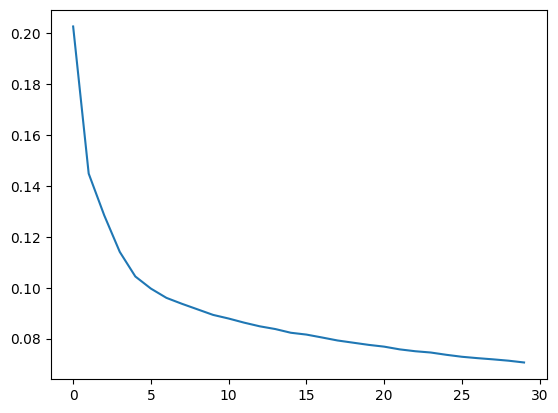

In [52]:
import matplotlib.pyplot as plt
plt.plot(losses)

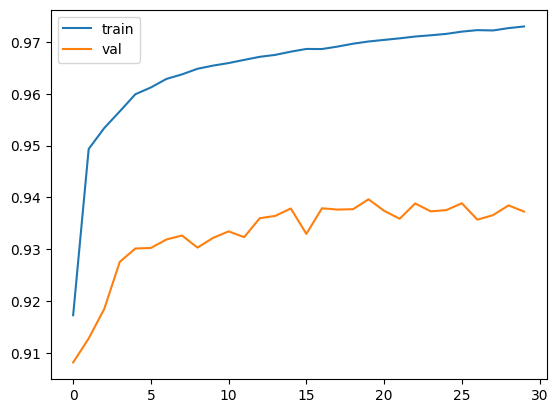

In [53]:
fig, ax = plt.subplots()

ax.plot(accuracies, label="train")
ax.plot(val_accuracies, label="val")
ax.legend()



## Visualizing the data
The prgram midi2vid can be used to visualize the midi files events.
if the right or left attribute is not set, the program will use a separate color. 
This can be used to visualize the wrong predictions of the model.

```
python3 src/main.py --source_path=/Users/oscar/pro/midi2hands/data/Bach-ItalienischesKonzert.mid --output_path=/Users/oscar/pro/midi2hands/data/Bach-ItalienischesKonzert.mp4 --events_path=/Users/oscar/pro/midi2hands/events/Bach-ItalienischesKonzert.json

python3 src/main.py --source_path=/Users/oscar/pro/midi2hands/data/Bach-ItalienischesKonzert.mid --output_path=/Users/oscar/pro/midi2hands/data/Bach-ItalienischesKonzert.mp4 --events_path=/Users/oscar/pro/midi2hands/events/Bach-ItalienischesKonzert.json
```

python3 src/main.py --source_path=/Users/oscar/pro/midi2hands/data/data/Mendelssohn-LiederOhneWorte_Band1No19.mid --output_path=/Users/oscar/pro/midi2hands/data/Bach-ItalienischesKonzert.mp4 --events_path=/Users/oscar/pro/midi2hands/events/valid_sample1.json

In [86]:
mp = MidiEventProcessor()

# get one file from the test paths
file_path = val_paths[3]
print(file_path)

# extract the note events
events = mp.extract_note_events(file_path)
print(len(events))

# run inference on the events


def run_inference(events, model, window_size):
    y_pred = []
    # events = pad_events(events, window_size)
    for i in range(0, len(events), 1):
        if i < window_size:
            window = events[0:i+1]
        else:
            window = events[i-window_size:i+1]
        window = preprocess_window(window)
        window = torch.tensor(window).float().to(device).unsqueeze(0)
        output = model(window)
        output = torch.sigmoid(output).squeeze().cpu().detach().numpy()
        print(output)
        output = 0 if output < 0.5 else 1
        y_pred.append(output)
    print("outputs", len(y_pred))
    print("events", len(events))
    assert len(y_pred) == len(events)
    return y_pred

def run_inference2(events, model, window_size):
    y_pred = []
    padded_events = pad_events(events.copy(), window_size)
    print("padded events", len(padded_events))
    print("events", len(events))
    h = window_size // 2
    for i in range(h, len(events) + h, 1):
        # 1. extract the window
        window_events = padded_events[i-h : i+h]
        assert len(window_events) == window_size
        # 2. preprocess the window
        preprocessed_window = preprocess_window(window_events)

        # 3. get the label
        label = padded_events[i].hand
        label = convert_hand_to_number(label)

        tensor_window = torch.tensor(preprocessed_window).float().to(device).unsqueeze(0)

        output = model(tensor_window)
        output = torch.sigmoid(output).squeeze().cpu().detach().numpy()
        # print(output)
        output = 0 if output < 0.5 else 1
        y_pred.append(output)
    print("outputs", len(y_pred))
    print("events", len(events))
    assert len(y_pred) == len(events)
    return y_pred

def inference(path, model, window_size):
    mp = MidiEventProcessor()
    events = mp.extract_note_events(path)
    y_pred = run_inference2(events, model, window_size)
    return y_pred

y_pred = run_inference2(events, model, window_size=30)

# compare the outputs with the ground truth, 0 is left hand, 1 is right hand
y_true = [0 if event.hand == "left" else 1 for event in events]

print(f"Acuuracy for {file_path.name}: {accuracy(y_true, y_pred)}")

# update the events with the predictions
for i, event in enumerate(events):
    # set none on incorrect predictions
    if y_pred[i] != y_true[i]:
        event.hand = None

# now we should be able to visualize the events


data/train/010-BachJS-FrzSuite2_Menuett.mid
268
padded events 298
events 268
outputs 268
events 268
Acuuracy for 010-BachJS-FrzSuite2_Menuett.mid: 0.9291044776119403


In [87]:
print(y_true)
print(y_pred)

[0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,

In [85]:
to_json(events, Path("events/valid_sample1.json"))

In [23]:
from pathlib import Path

def extract_windows_from_files(paths, window_size, step_size):
    all_windows = []
    all_labels = []
    mp = MidiEventProcessor()
    for path in tqdm(paths):
        events = mp.extract_note_events(path)
        windows, labels = extract_windows_and_labels(events, window_size, step_size, bidirectional=True)
        all_windows.extend(windows)
        all_labels.extend(labels)
    return np.array(all_windows), np.array(all_labels)

def k_fold_split(k):
    paths = list(Path("data").rglob("*.mid"))
    n = len(paths)
    fold_size = n // k
    folds = []
    for i in range(k):
        start = i * fold_size
        end = (i + 1) * fold_size
        val_fold = paths[start:end]
        train_fold = paths[:start] + paths[end:]
        folds.append((train_fold, val_fold))
    return folds

In [37]:
k_fold_data = k_fold_split(10)
data_sets = []
for train_paths, val_paths in k_fold_data:
    train_windows, train_labels = extract_windows_from_files(
        train_paths, window_size=30, step_size=1
    )
    val_windows, val_labels = extract_windows_from_files(
        val_paths, window_size=30, step_size=1
    )

    # create a data loader
    train_dataset = MidiDataset(train_windows, train_labels)
    val_dataset = MidiDataset(val_windows, val_labels)
    data_sets.append((train_dataset, val_dataset))

100%|██████████| 12/12 [00:00<00:00, 18.53it/s]


In [48]:
batch_size = 64
for T,V in data_sets:
    print(len(T)%batch_size, len(V)%batch_size)

50 33
12 7
49 34
50 33
43 40
50 33
33 50
9 10
15 4
54 29


In [42]:
paths = list(Path("data").rglob("*.mid"))
print(len(paths))

122
